In [1]:
import warnings

warnings.filterwarnings("ignore")
import os

if "jbook" in os.getcwd():
    os.chdir(os.path.abspath(os.path.join("../..")))
FORCE = True

# Text Quality Scoring Method for Pretraining Large Language Models
In this unsupervised learning approach, we begin by pretraining an initial model on unlabeled app review samples to generate pseudolabels, which will then be used to fine-tune a large language model (LLM) for Aspect-Based Sentiment Analysis (ABSA). The core challenge is selecting high-quality, diverse samples to label effectively, as this directly impacts the model’s downstream performance. For this, we will employ a custom text quality scoring method inspired by state-of-the-art research, which includes various features such as part-of-speech diversity, and syntactic and structural complexity. This scoring method enables filtering for the most informative samples that adequately capture the dataset's diversity, helping ensure that pseudolabels are representative of nuanced sentiment and aspect distributions. This selection process enhances the quality of the fine-tuning dataset and, ultimately, the precision of the LLM ABSA model's insights.

Our **Text Quality Scoring Method** will combine two weighted text quality measures that capture distinct aspects of linguistic quality: **Syntactic Complexity** and **Perplexity**.

1. **Syntactic Complexity Score**:
   - This component evaluates the structural richness of the text, focusing on aspects like **Part-of-Speech (POS) density, POS diversity, and sentence structure complexity**. By examining syntactic elements, this score captures how linguistically complex and detailed a text is.
   - A high Syntactic Complexity Score typically indicates a text rich in linguistic features, with varied sentence structures and a well-balanced mix of nouns, verbs, and modifiers (like adjectives and adverbs). This variety is particularly valuable for tasks like Aspect-Based Sentiment Analysis (ABSA), where structural complexity can signal content with nuanced aspects and sentiments.

2. **Perplexity-Based Score**:
   - The Perplexity-Based Score measures the **predictability and coherence** of the text from the perspective of a language model. It reflects how well the text aligns with natural language patterns, as determined by a pre-trained model (e.g., GPT).
   - Lower perplexity implies higher fluency, coherence, and grammatical correctness, which are key indicators of text quality. This component is useful for flagging low-quality or noisy text that may be unpredictable or deviate significantly from standard linguistic norms.

### Weighted Scoring Approach
To create a balanced quality score, the Syntactic Complexity Score and Perplexity-Based Score are combined with tailored weights that emphasize their respective strengths. 

- **Syntactic Complexity Weight**: Typically given more weight when the task demands detailed and linguistically rich text, such as ABSA, where richer syntactic content improves aspect and sentiment extraction.
- **Perplexity-Based Weight**: Often assigned a moderate weight to capture coherence and fluency, ensuring that only grammatically sound and predictable text is prioritized without sacrificing syntactic diversity.

The final **Text Quality Score** is a weighted average of these two components, providing a single score that balances both syntactic richness and linguistic fluency. The remainder of this notebook will execute the text quality scoring pipeline, computing and integrating the two quality measures into a final text quality score. The specifics of the measures are provided in {ref}`Text Quality Method` Section of the appendix.   


## Import Libraries

In [12]:
import pandas as pd
from discover.container import DiscoverContainer
from discover.infra.config.flow import FlowConfigReader
from discover.core.namespace import NestedNamespace
from discover.assets.dataset import Dataset
from discover.core.flow import DataPrepStageDef, PhaseDef
from discover.assets.idgen import AssetIDGen
from discover.flow.data_prep.tqa.task import TQATask1, TQATask2, TQATask2Data, TQATask3

pd.options.display.max_colwidth = 50

## Dependency Container

In [3]:
container = DiscoverContainer()
container.init_resources()
container.wire(
    modules=[
        "discover.flow.data_prep.stage",
    ],
)

## TQA Configuration

In [4]:
# Obtain the configuration for the tqa stage
reader = FlowConfigReader()
config = reader.get_config("phases", namespace=False)
stage_config = NestedNamespace(config["dataprep"]["stages"]["tqa"])

## Load Data
Data from the feature engineering stage will be used to compute text quality scores.

In [5]:
# Obtain the asset id for the feature engineering dataset
asset_id = AssetIDGen.get_asset_id(
    asset_type="dataset",
    phase=PhaseDef.DATAPREP,
    stage=DataPrepStageDef.FEATURE,
    name="review",
)
# Instantiate the repository
repo = container.repo.dataset_repo()
# Load the dataset from the repository
df = repo.get(asset_id, distributed=False).content

## TQA 1: Syntactic Complexity Scores
Compute syntactic complexity scores

In [ ]:
task = TQATask1(
    pos_count_weight=stage_config.tasks[0]["params"]["pos_count_weight"],
    pos_diversity_weight=stage_config.tasks[0]["params"]["pos_diversity_weight"],
    pos_intensity_weight=stage_config.tasks[0]["params"]["pos_intensity_weight"],
    structural_complexity_weight=stage_config.tasks[0]["params"][
        "structural_complexity_weight"
    ],
    tqa_check_weight=stage_config.tasks[0]["params"]["tqa_check_weight"],
)
df = task.run(data=df)
df["enrichment_tqa_score1"].describe().to_frame().T



                                    TQATask1                                    
                                    --------                                    
                          Start Datetime | Mon, 04 Nov 2024 16:56:08
                       Complete Datetime | Mon, 04 Nov 2024 16:56:14
                                 Runtime | 5.6 seconds


,count,mean,std,min,25%,50%,75%,max
enrichment_tqa_score1,55692.0,0.482884,0.100878,0.0,0.448852,0.50311,0.544358,2.631612


The data suggests a relatively normal distribution for syntactic complexity scores, with a slight right skew due to high outliers (maximum of 2.63). Most of the values are within a narrow band around the mean, clustering in the 0.45 to 0.55 range, with few entries significantly diverging from this range. The relatively low minimum and maximum scores indicate a diverse range, but the clustering near the central values suggests consistency in `enrichment_tqa_score1` across the dataset.

## TQA 2: Compute Perplexity-Based Quality Score
The next stage in our TQA assessment pipeline involves computing text quality scores using a two-step perplexity-based method. First, we obtain a representative random sample from our dataset, then we calculate weights for 12 linguistic filters, selected from a diverse set of over 50 features of well-formed sentences, consistently associated with perplexity improvements.

| #  | Filter                        | Description                                               |
|----|-------------------------------|-----------------------------------------------------------|
| 1  | Adjectives                    | True if the review contains an adjective                  |
| 2  | Adverbs                       | True if the review contains at least one adverb           |
| 3  | Determiners                   | True if the review contains at least one determiner       |
| 4  | Nouns                         | True if the review contains at least one noun             |
| 5  | Verbs                         | True if the review contains at least one verb             |
| 6  | Terminal Punctuation          | Whether the review has terminal punctuation               |
| 7  | Word Count Range              | Whether the word count is in range [3,256]                |
| 8  | High Special  Character Ratio | Whether the ratio of special characters exceeds 0.25      |
| 9  | Stop Word Match               | Whether the review contains any of 8 selected stopwords   |
| 10 | First Letter Capitalized      | Whether the first letter of the first word is capitalized |
| 11 | High Word Repetition          | Whether the word repetition ratio exceeds 0.2             |
| 12 | No Special Characters         | Whether the review contains special characters            |

These weights are determined by evaluating how each filter affects validation perplexity, with higher weights assigned to filters that reduce perplexity. For validation perplexity calculations, we used the pretrained GPT-2 model cite`radford2019language`. In the second step, we apply these filters to assess review-level quality, generating a weighted average score that emphasizes well-structured text while maintaining scalability across large datasets. The heuristics are listed in the {ref}`Text Quality Method` Section.

In [ ]:
# Sample for perplexity-weight computations
task = TQATask2Data(
    min_review_length=stage_config.tasks[1]["params"]["min_review_length"],
    max_review_length=stage_config.tasks[1]["params"]["max_review_length"],
    frac=stage_config.tasks[1]["params"]["frac"],
    random_state=stage_config.tasks[1]["params"]["random_state"],
    filepath=stage_config.tasks[1]["params"]["filepath"],
)
task.run(data=df)

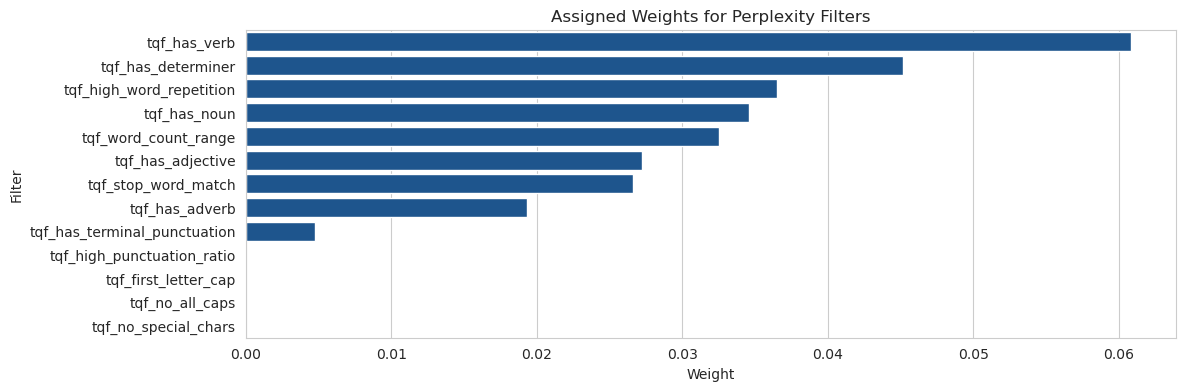

In [ ]:
# Weights
task = TQATask2(
    weights_filepath=stage_config.tasks[2]["params"]["weights_filepath"],
    ppl_full=stage_config.tasks[2]["params"]["ppl_full"],
    column=stage_config.tasks[2]["params"]["column"],
    new_column=stage_config.tasks[2]["params"]["new_column"],
)

task.plot_weights()

This bar chart provides a view of the assigned weights for each of the 12 perplexity-based filters. Filters like **tqf_has_verb**, **tqf_has_determiner**, and **tqf_high_word_repetition** have the highest weights, indicating their strong influence on reducing perplexity and improving text quality. Meanwhile, filters such as **tqf_has_terminal_punctuation** and those related to special characters and capitalization have lower weights, suggesting a lesser impact on text quality in this context. 

Next, quality scores are computed as the weighted sum of the filter indicators for each review and the filter weights. 

In [ ]:
df = task.run(data=df)
df["enrichment_tqa_score2"].to_frame().describe().T

,count,mean,std,min,25%,50%,75%,max
enrichment_tqa_score2,55692.0,0.205715,0.073943,0.0,0.173911,0.23175,0.251087,0.287609


The data suggests that `enrichment_tqa_score2` values are generally lower and more consistently clustered around the mean, with a slight right skew. The low maximum score of 0.2876 indicates minimal high outliers, reinforcing the idea that `enrichment_tqa_score2` is distributed within a narrow band. This consistency could imply that `enrichment_tqa_score2` is measuring a more restricted or specific aspect of quality, leading to less variability than `enrichment_tqa_score1`.

## Text Quality Composite Score
To calculate the final quality score, we normalize each individual `tqa_score` to a [0, 1] range, ensuring consistency and comparability across scores. After normalization, we apply a weighted sum, combining the normalized scores based on their respective importance (weights) to derive a comprehensive quality score. This final score reflects the cumulative text quality, balancing multiple aspects captured by each score and emphasizing the features most indicative of high-quality text.

,count,mean,std,min,25%,50%,75%,max
enrichment_tqa_score_final,55692.0,0.502552,0.165517,0.0,0.432367,0.557046,0.607667,0.737036


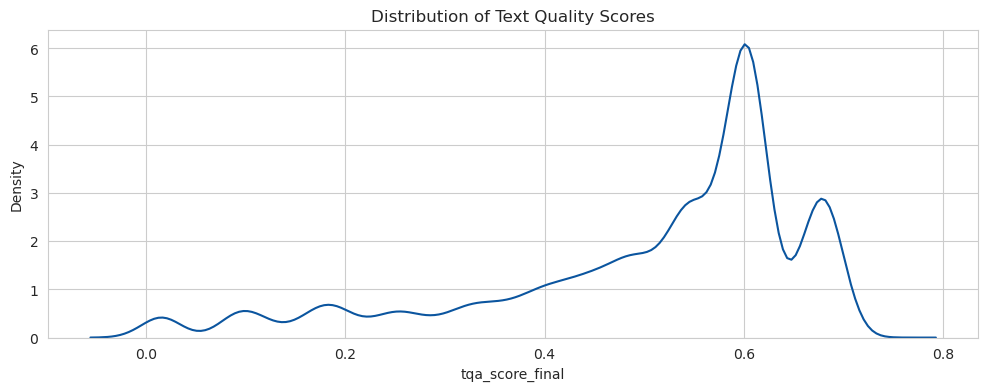

In [ ]:
task = TQATask3(tqa1_weight=0.4, tqa2_weight=0.6)
df = task.run(data=df)
task.plot_scores()
df["enrichment_tqa_score_final"].describe().to_frame().T

After normalization and weighted summation, the score distribution appears multimodal, with a prominent peak around 0.6, suggesting that a large portion of the dataset is assessed with mid-to-high quality. The presence of smaller peaks and variations below this value indicates diverse quality levels across the text samples, capturing a range of text structures and linguistic features. The clustering toward the higher end suggests that the dataset includes substantial well-formed text, though there are instances of lower quality as well.

Let's save the data.

In [ ]:
dataset = Dataset(
    phase=PhaseDef.DATAPREP,
    stage=DataPrepStageDef.TQA,
    name="reviews",
    content=df,
    distributed=False,
)
df = repo.add(dataset=dataset)

[11/04/2024 05:21:05 PM] [INFO] [discover.infra.persistence.repo.dataset.DatasetRepo] [_remove_dataset_file_by_filepath] : Removed dataset file at workspace/dev/dataset/01_dataprep/appvocai_discover-01_dataprep-03_tqa-reviews-dataset.parquet from repository.
[11/04/2024 05:21:05 PM] [INFO] [discover.infra.persistence.repo.dataset.DatasetRepo] [remove] : Removed dataset dataset-dev-dataprep-tqa-reviews from the repository.


## Summary
The dataset is now enriched with quality scores that reflect the structural and linguistic richness of each review. This concludes the data preparation stage, Next, we'll select 100,000 of the highest quality reviews for pretraining This dataset provides a foundation for further selection, where high-quality samples can be identified for pseudolabeling and other downstream tasks. Next, we will examine how the scores and data are distributed at different quality thresholds. 